In [1]:
%load_ext autoreload
%autoreload 2

#### Make sure you downloaded coco, flickr, glove. If not uncomment cell below.

In [1]:
#!bash ../load_flickr8k.sh
#!bash ../load_glove.sh
#!bash ../load_coco.sh

In [3]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [6]:
import pickle

from datasets.flickr8k import Flickr8kDataset


DATASET_BASE_PATH = '../data/flickr8k/'
VOCAB = 'vocab_set.pkl'

train_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train',
    device=device, return_type='tensor', load_img_to_memory=False)


vocab_set = train_set.get_vocab()
with open(VOCAB, 'wb') as f:
    pickle.dump(vocab_set, f)
    

vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)

val_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

test_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

train_eval_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)


print(
    f"The number of samples in:\ntrain: {len(train_set)};"
    + f" validation: {len(val_set)}; test: {len(test_set)}\n"
    + f"Vocabulary size: {vocab_size}; Max length of a sentence: {max_len};"
)

The number of samples in:
train: 30000; validation: 1000; test: 1000
Vocabulary size: 7708; Max length of a sentence: 40;


In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.coco import CoCoDataloader

BATCH_SIZE = 16

eval_transformations = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn, drop_last=True)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn, drop_last=True)

vocab_from_file = True     # if True, load existing vocab file

coco_val_loader = CoCoDataloader(transform=eval_transformations,
                        batch_size=BATCH_SIZE,
                        vocab_from_file=vocab_from_file,
                        vocab_file='vocab_set.pkl',
                        img_folder='../data/coco/val2014',
                        annotations_file='../data/coco/annotations/captions_val2014.json')


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [9]:
start_token = word2idx['<start>']
end_token = word2idx['<end>']
pad_token = word2idx['<pad>']
max_seq_len = max_len

In [4]:
import random
import torch
import numpy as np
from models.torch.diet_lstm import Captioner

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


In [11]:
from glove import embedding_matrix_creator
EMBEDDING_DIM = 50
EMBEDDING = f"GLV{EMBEDDING_DIM}"

embedding_matrix = embedding_matrix_creator(embedding_dim=EMBEDDING_DIM, word2idx=word2idx, GLOVE_DIR='../data/glove.6B/')
print(f"Embedding matrix shape: {embedding_matrix.shape}")

  0%|          | 0/7708 [00:00<?, ?it/s]

Embedding matrix shape: (7708, 50)


In [12]:
from metrics import *
from utils_torch import words_from_tensors_fn
import numpy as np
from tqdm import tqdm
from train_torch import evaluate_model

sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_set.pad_value)

In [ ]:
"""
If you want to evaluate your trained model just ignore this cell
"""
! gdown 10lnR-5Lkz9GabZ17Gj-sxfJ-QkiQ7Qbg
!mkdir -p saved_models/ViT_lstm
!mv ViT_lstm_b16_emdGLV50_ep_19_weights.pt saved_models/ViT_lstm/ViT_lstm_b16_emdGLV50_best_val_bleu.pt

In [ ]:
NUM_HEADS_DEC = 10
NUM_LAYERS_DEC = 6

path = 'saved_models/ViT_lstm/ViT_lstm_b16_emdGLV50_best_val_bleu.pt'
checkpoint = torch.load(path)

EMBEDDING_DIM = 50
HIDDEN_SIZE = 256
model = Captioner(EMBEDDING_DIM, HIDDEN_SIZE, vocab_size, num_layers=1,
                            embedding_matrix=embedding_matrix, train_embd=False).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

### Flickr

In [ ]:
inter_params = {
    'model': model,
    'bleu_score_fn': corpus_bleu_score_fn,
    'tensor_to_word_fn': tensor_to_word_fn,
    'data': 'flickr',
    'device': device
}

with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(
        desc=f'Train: ',
        data_loader=train_eval_loader,
        **inter_params,
    )
    
    val_bleu = evaluate_model(
        desc=f'Val: ',
        data_loader=val_loader,
        **inter_params,
    )
    
    test_bleu = evaluate_model(
        desc=f'Test: ',
        data_loader=test_loader,
        **inter_params,
    )

    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')

Test: 100%|██████████| 62/62 [00:19<00:00,  3.12it/s, bleu1=0.535, bleu4=0.106]


train Bleu-1: 0.560664392694209 Bleu-2: 0.344044306225595 Bleu-3: 0.20979931600993912 Bleu-4: 0.1324885376599284 
val Bleu-1: 0.5323317282615447 Bleu-2: 0.30864491409316036 Bleu-3: 0.176208560819316 Bleu-4: 0.10913453134724929 
test Bleu-1: 0.5348780746392873 Bleu-2: 0.3106018479664104 Bleu-3: 0.1761348588678447 Bleu-4: 0.1061863001711077 


### COCO

In [ ]:
with torch.no_grad():
    val_bleu = evaluate_model(
                    desc=f'\tValidation Bleu Score: ',
                    model=model,
                    data='coco',
                    bleu_score_fn=corpus_bleu_score_fn,
                    tensor_to_word_fn=tensor_to_word_fn,
                    data_loader=coco_val_loader,
                    device=device
                )
    print('val', end=' ')
    for ngram in (1, 2, 3, 4):
        print(f'Bleu-{ngram}: {val_bleu[ngram]}', end=' ')

# Caption generation

In [19]:
import matplotlib.pyplot as plt

from utils_torch import (
    words_from_tensors_fn,
    get_picture_caption,
)

from metrics import bleu_score_fn, accuracy_fn

In [ ]:
from datasets.coco import CoCoDataset

coco_set = CoCoDataset(transform=eval_transformations,
                      batch_size=BATCH_SIZE,
                      vocab_threshold=None,
                      vocab_file='vocab_set.pkl',
                      start_word="<start>",
                      end_word="<end>",
                      unk_word="<unk>",
                      annotations_file='../data/coco/annotations/captions_val2014.json',
                      vocab_from_file=vocab_from_file,
                      img_folder='../data/coco/val2014')

In [21]:
from utils_torch import get_picture_caption

In [22]:
dset = coco_set

idx_range = [26, 56, 23, 52, 80]

model_name = 'ViT + LSTM'

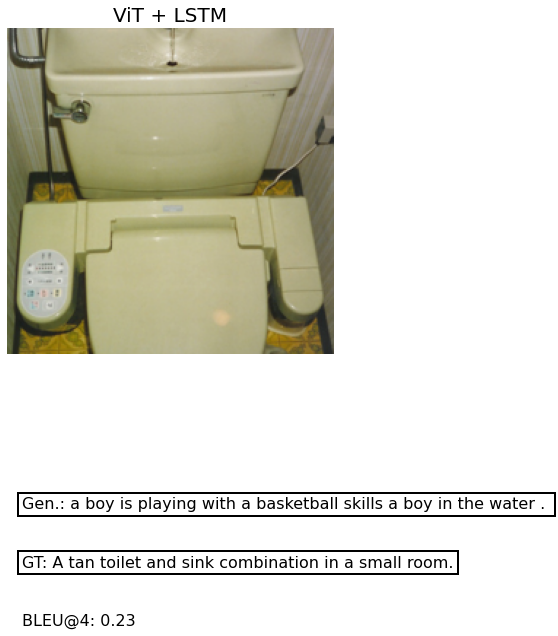

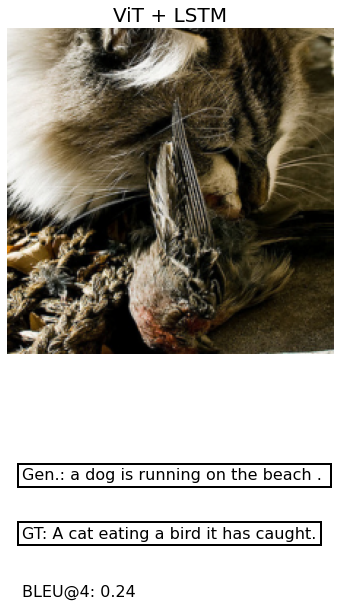

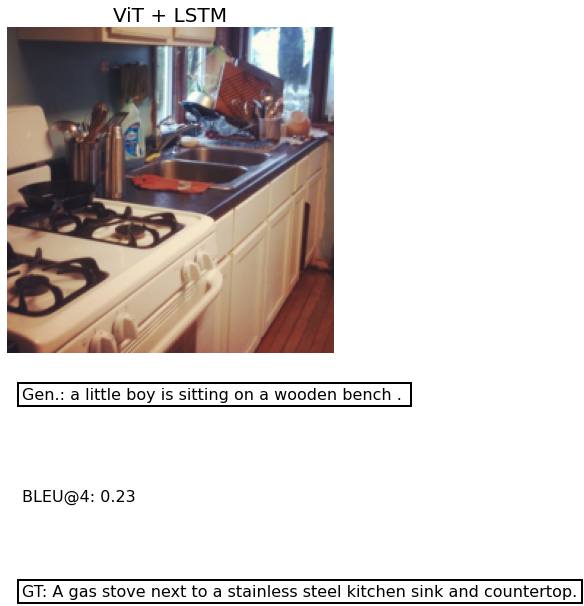

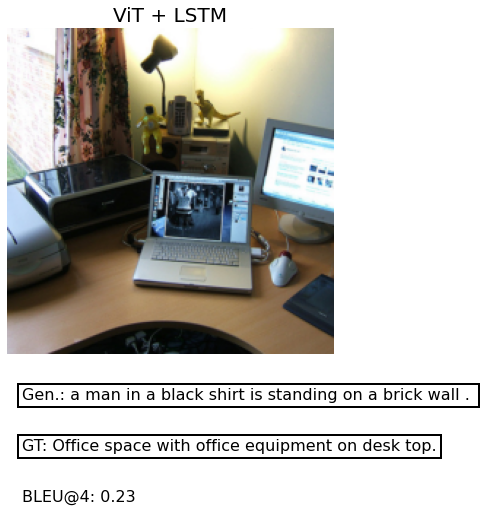

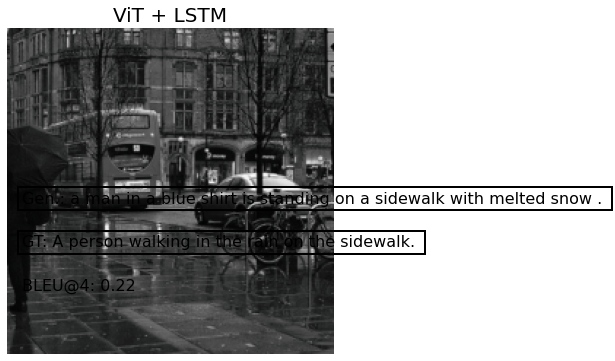

In [ ]:
spatial = (
    ((10, 330), (10, 370), (10, 410)),
    ((10, 310), (10, 350), (10, 390)),
    ((10, 255), (10, 390), (10, 325)),
    ((10, 255), (10, 290), (10, 325)),
    ((10, 120), (10, 150), (10, 180)),
)

idx2spatial = {i:v for i, v in zip(idx_range, spatial)}

for idx in idx2spatial:
    x1_y1, x2_y2, x3_y3 = idx2spatial[idx]
    generated_caption = get_picture_caption(idx, dset, model, idx2word)
    score = f"BLEU@4: {bleu_score_fn(4, 'corpus')([[i.split() for i in dset.__getitem__(idx)[1]]], [generated_caption.split()], n=4):0.2f}"
    transform = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                   transforms.ToPILImage(),
                               ])
    img = transform(dset.__getitem__(idx)[0])
    plt.figure(figsize=(12, 6), facecolor="white")
    plt.imshow(img)
    plt.axis('off')
    plt.title(model_name, fontsize=20)
    plt.text(
        *x1_y1, "Gen.: " + generated_caption,
        fontsize=16, bbox=dict(fill=False, edgecolor='black', linewidth=2)
    )
    plt.text(
        *x2_y2, "GT: " + dset.__getitem__(idx)[1],
        fontsize=16, bbox=dict(fill=False, edgecolor='black', linewidth=2)
    )
    plt.text(
        *x3_y3, score,
        fontsize=16,
    )
    plt.show()